1. Implement Oja's rule, Sanger's rule, Foldiak's rule and BCM rule on Laplacian
2. Compare using linear, Relu, Sigmoid, tanh activation function

In [1]:
# Import libraries
%reset -f
%reload_ext autoreload

# %load BCM_running.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import argparse
import seaborn as sns
%matplotlib inline
from local_lr import data_loader
from local_lr import BCM_cl
from local_lr import BCM_fully_connect_cl as BCM
import pandas as pd
# Reset tf.app.flags.FLAGS

from tensorflow.python.framework import ops
ops.reset_default_graph()

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


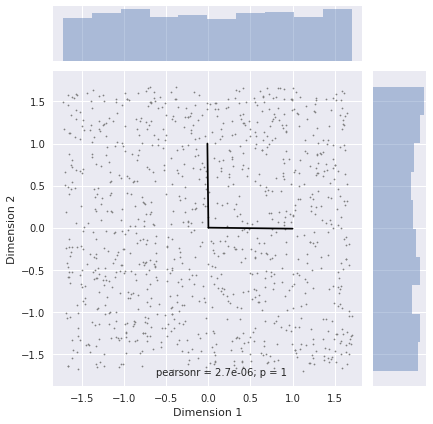

In [2]:
# Load dataset
data, data_w = data_loader.load_uniform(loc = 0, scale = 1, sample_size = 1000 , dimension = 2,seed=0, skew = False, whiten = True, rotation = False, Affine = False, iffigure = True)
# Plot the scaled version of independent direction (unit length)
w_tmp = data_w
w_norm = np.sqrt(np.sum(np.square(w_tmp), keepdims=True, axis=1))
w_tmp = w_tmp/w_norm 

plt.plot([0,w_tmp[0][0]],[0,w_tmp[0][1]],'k', label = 'Ground truth')
plt.plot([0,w_tmp[1][0]],[0,w_tmp[1][1]],'k')
#plt.plot(data_w[:,0], data_w[:,1],'.k', ms=4)
plt.gca().set_aspect(1)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


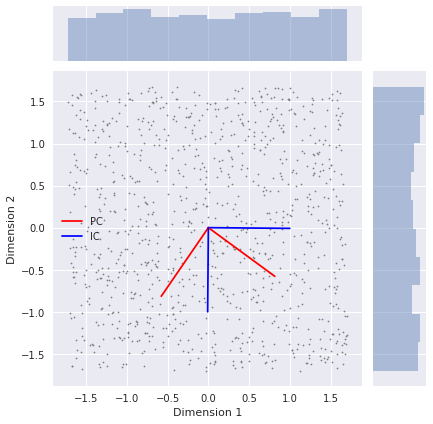

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_std=False)
data_scaled = scaler.fit_transform(data)

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

df = pd.DataFrame({'x': data_scaled[:, 0], 'y': data_scaled[:, 1]})
g = sns.jointplot(x="x", y="y", data=df)
g.plot_joint(plt.scatter, c="gray", s=10, linewidth=.1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Dimension 1", "Dimension 2")

n_components = 2
pca = PCA(n_components)
pca.fit_transform(data_scaled)
PC2 = pca.components_

ica = FastICA(n_components)
ica.fit_transform(data_scaled)
IC2 = ica.components_
IC_norm = np.sqrt(np.sum(np.square(IC2), keepdims=True, axis=1))
IC2 = IC2/IC_norm

for i in range(n_components):
    if i == 0:
        plt.plot([0,PC2[i,0]], [0,PC2[i,1]], 'r', label='PC')
        plt.plot([0,IC2[i,0]], [0,IC2[i,1]], 'b', label='IC')
    else:
        plt.plot([0,PC2[i,0]], [0,PC2[i,1]], 'r')
        plt.plot([0,IC2[i,0]], [0,IC2[i,1]], 'b')
    plt.legend()

In [20]:
# Train with Oja's learning rule, plot the trajectory
from local_lr import Oja_cl

learning_rate = 0.0001
epoch = 5000
np.random.seed(1)
n_input = 2
n_output = 2
w_init = np.random.randn(n_input, n_output)
nonlinear= [None, 'relu', 'sigmoid', 'tanh']

kwarg = {}
w_track = {}
w_final = {}
for i in range(len(nonlinear)):
    w_track_tmp = []
    oja_fw, oja_up = Oja_cl.oja(eta=learning_rate, act=nonlinear[i])
    kwarg['w'] = w_init
    for j in range(epoch):
        w_track_tmp.append(kwarg['w'].reshape(-1,1))
        y = oja_fw(data, **kwarg)
        kwarg = oja_up(data, y, **kwarg)
    w_track[nonlinear[i]] = w_track_tmp
    w_final[nonlinear[i]] = kwarg['w']

In [21]:
PC2

array([[-0.57835086, -0.81578814],
       [ 0.81578814, -0.57835086]])

In [22]:
w_final[None]

array([[ 0.95124526, -0.49555061],
       [-0.3084355 , -0.86857907]])

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


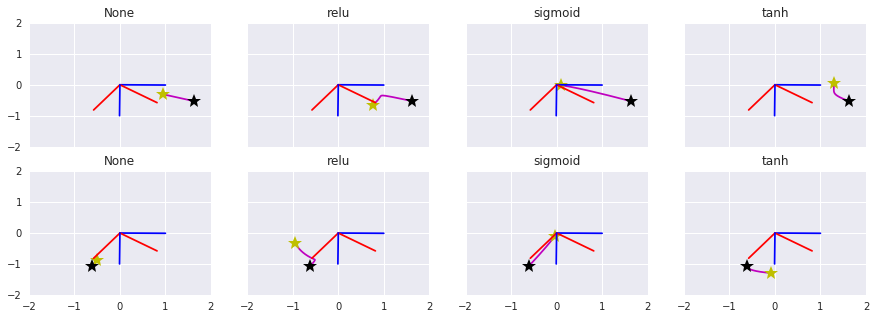

In [23]:
# Plot the training trajectory
n_row = n_output 
n_col = 4

fig, ax = plt.subplots(n_row ,n_col, sharex=True, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(15)
for i in range(n_row):
    for j in range(n_col):
        nonlinear_type = nonlinear[j]
        data_w = np.hstack(w_track[nonlinear_type])
        if n_row > 1:
            g = ax[i][j]
        else:
            g = ax[j]
        
        g.plot(data_w[i,:], data_w[i + n_row,:], 'm', rasterized= True)
        g.plot(data_w[i,-1], data_w[i + n_row,-1], 'y*', ms=15, rasterized= True)
        g.set_title(nonlinear_type)
        g.plot(data_w[i, 0], data_w[i+n_row, 0], 'k*', ms=15, rasterized= True)
        g.set_xlim([-5,5])
        g.set_ylim([-5,5])
        
        for k in range(n_components):
            g.plot([0,PC2[k,0]], [0,PC2[k,1]], 'r')
            g.plot([0,IC2[k,0]], [0,IC2[k,1]], 'b')
        
        g.set_xlim([-2,2])
        g.set_ylim([-2,2])

In [8]:
# Train with Oja's learning rule, plot the trajectory
from local_lr import Sanger_cl

learning_rate = 0.0005
epoch = 3000
np.random.seed(1)
n_input = 2
n_output = 2
w_init = np.random.randn(n_input, n_output)
nonlinear= [None, 'relu', 'sigmoid', 'tanh']

kwarg = {}
w_track = {}
w_final = {}
for i in range(len(nonlinear)):
    w_track_tmp = []
    sanger_fw, sanger_up = Sanger_cl.sanger(eta=learning_rate, act=nonlinear[i])
    kwarg['w'] = w_init
    for j in range(epoch):
        w_track_tmp.append(kwarg['w'].reshape(-1,1))
        y = sanger_fw(data_scaled, **kwarg)
        kwarg = sanger_up(data, y, **kwarg)
    w_track[nonlinear[i]] = w_track_tmp
    w_final[nonlinear[i]] = kwarg['w']

In [9]:
PC2

array([[-0.57835086, -0.81578814],
       [ 0.81578814, -0.57835086]])

In [10]:
w_final[None]

array([[ 0.95176198, -0.30683891],
       [-0.30683732, -0.95176146]])

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


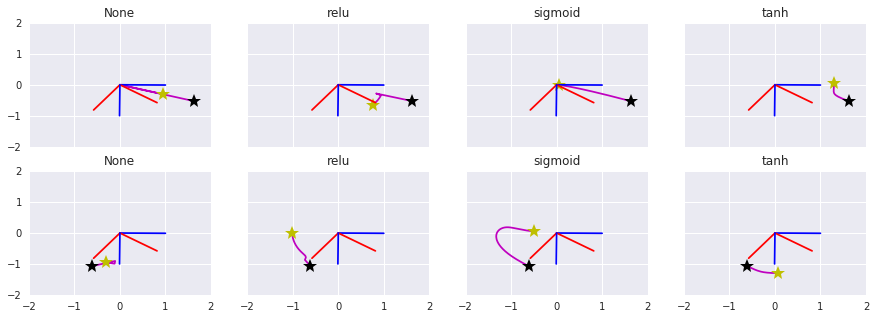

In [11]:
# Plot the training trajectory
n_row = n_output 
n_col = 4

fig, ax = plt.subplots(n_row ,n_col, sharex=True, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(15)
for i in range(n_row):
    for j in range(n_col):
        nonlinear_type = nonlinear[j]
        data_w = np.hstack(w_track[nonlinear_type])
        if n_row > 1:
            g = ax[i][j]
        else:
            g = ax[j]
        
        g.plot(data_w[i,:], data_w[i + n_row,:], 'm', rasterized= True)
        g.plot(data_w[i,-1], data_w[i + n_row,-1], 'y*', ms=15, rasterized= True)
        g.set_title(nonlinear_type)
        g.plot(data_w[i, 0], data_w[i+n_row, 0], 'k*', ms=15, rasterized= True)
        g.set_xlim([-5,5])
        g.set_ylim([-5,5])
        
        for k in range(n_components):
            g.plot([0,PC2[k,0]], [0,PC2[k,1]], 'r')
            g.plot([0,IC2[k,0]], [0,IC2[k,1]], 'b')
        
        g.set_xlim([-2,2])
        g.set_ylim([-2,2])

In [12]:
# Train with Foldiaks's learning rule, plot the trajectory
from local_lr import Foldiak_cl

learning_rate = 0.0001
epoch = 5000
np.random.seed(1)
n_input = 2
n_output = 2
w_init = np.random.randn(n_input, n_output)
q_init = -1 * np.tril(np.random.rand(n_output,n_output), -1)
nonlinear= [None, 'relu', 'sigmoid', 'tanh']

kwarg = {}
w_track = {}
w_final = {}
for i in range(len(nonlinear)):
    w_track_tmp = []
    foldiak_fw, foldiak_up = Foldiak_cl.foldiak(eta=learning_rate, act=nonlinear[i])
    kwarg['w'] = w_init
    kwarg['q'] = q_init
    for j in range(epoch):
        w_track_tmp.append(kwarg['w'].reshape(-1,1))
        y = foldiak_fw(data, **kwarg)
        kwarg = foldiak_up(data_scaled, y, **kwarg)
    w_track[nonlinear[i]] = w_track_tmp
    w_final[nonlinear[i]] = kwarg['w']

In [13]:
PC2

array([[-0.57835086, -0.81578814],
       [ 0.81578814, -0.57835086]])

In [14]:
w_final[None]

array([[ 0.86857935, -0.49555061],
       [-0.49555012, -0.86857907]])

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


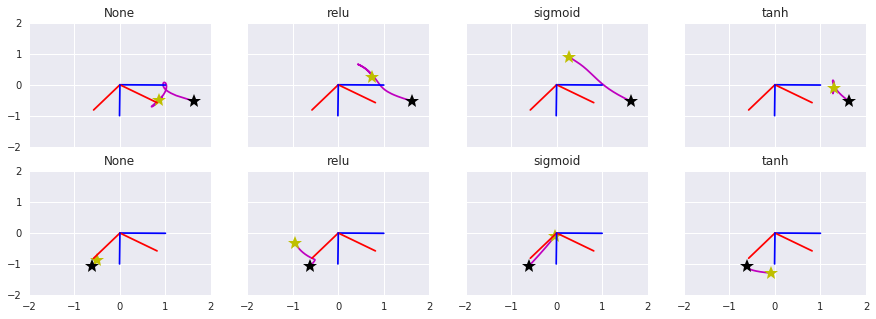

In [15]:
# Plot the training trajectory
n_row = n_output 
n_col = 4

fig, ax = plt.subplots(n_row ,n_col, sharex=True, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(15)
for i in range(n_row):
    for j in range(n_col):
        nonlinear_type = nonlinear[j]
        data_w = np.hstack(w_track[nonlinear_type])
        if n_row > 1:
            g = ax[i][j]
        else:
            g = ax[j]
        
        g.plot(data_w[i,:], data_w[i + n_row,:], 'm', rasterized= True)
        g.plot(data_w[i,-1], data_w[i + n_row,-1], 'y*', ms=15, rasterized= True)
        g.set_title(nonlinear_type)
        g.plot(data_w[i, 0], data_w[i+n_row, 0], 'k*', ms=15, rasterized= True)
        g.set_xlim([-5,5])
        g.set_ylim([-5,5])
        
        for k in range(n_components):
            g.plot([0,PC2[k,0]], [0,PC2[k,1]], 'r')
            g.plot([0,IC2[k,0]], [0,IC2[k,1]], 'b')
        
        g.set_xlim([-2,2])
        g.set_ylim([-2,2])

In [39]:
scaler2 = StandardScaler()
data_stand = scaler2.fit_transform(data)

In [63]:
# Training results BCM rule + linear, Relu, Sigmoid, tanh# 
from local_lr import QBCM_cl

learning_rate = 0.0001
epoch = 200
np.random.seed(10)
n_input = 2
n_output = 2
w_init = np.random.randn(n_input, n_output)
thres_init = np.zeros((1, n_output))
nonlinear= [None, 'relu', 'sigmoid', 'tanh']

kwarg = {}
w_track = {}
w_final = {}
for i in range(len(nonlinear)):
    w_track_tmp = []
    qbcm_fw, qbcm_up = QBCM_cl.qbcm(eta=learning_rate, act=nonlinear[i])
    kwarg['w'] = w_init
    kwarg['thres'] = thres_init
    for j in range(epoch):
        w_track_tmp.append(kwarg['w'].reshape(-1,1))
        kwarg = qbcm_up(data_scaled, **kwarg)
    w_track[nonlinear[i]] = w_track_tmp
    w_final[nonlinear[i]] = kwarg['w']

In [64]:
IC2

array([[ 0.99996377, -0.00851237],
       [-0.00850964, -0.99996379]])

In [65]:
w_final['relu']

array([[ 2.12848639,  2.12848769],
       [-2.18142827, -2.18142752]])

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


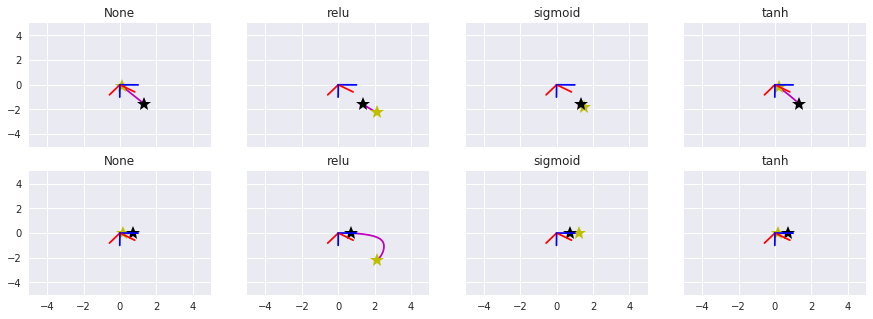

In [66]:
# Plot the training trajectory
n_row = n_output 
n_col = 4

fig, ax = plt.subplots(n_row ,n_col, sharex=True, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(15)
for i in range(n_row):
    for j in range(n_col):
        nonlinear_type = nonlinear[j]
        data_w = np.hstack(w_track[nonlinear_type])
        if n_row > 1:
            g = ax[i][j]
        else:
            g = ax[j]
        
        g.plot(data_w[i,:], data_w[i + n_row,:], 'm', rasterized= True)
        g.plot(data_w[i,-1], data_w[i + n_row,-1], 'y*', ms=15, rasterized= True)
        g.set_title(nonlinear_type)
        g.plot(data_w[i, 0], data_w[i+n_row, 0], 'k*', ms=15, rasterized= True)
        g.set_xlim([-5,5])
        g.set_ylim([-5,5])
        
        for k in range(n_components):
            g.plot([0,PC2[k,0]], [0,PC2[k,1]], 'r')
            g.plot([0,IC2[k,0]], [0,IC2[k,1]], 'b')
            g.legend()